# Setup

In [133]:
# import IPython
# import IPython.display
# import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
# import tensorflow as tf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from warnings import catch_warnings, filterwarnings
from tqdm.notebook import tqdm
# import itertools
# import statsmodels.api as sm
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima
# mpl.rcParams['figure.figsize'] = (16, 8)

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices("GPU")
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

## Display

In [34]:
# Facebook Prophet gives a number of info/warning messages which can't be suppressed using standard context manager 
# techniques. This code allows hiding cells which contain stderr output, which includes the Prophet messages.

# From answer given by user matthiash on StackOverflow at https://stackoverflow.com/a/43118091 
# Full discussion: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
nonimputed_train_file_name = 'Data/nonimputed_train.pkl'
nonimputed_train_df = pd.read_pickle(nonimputed_train_file_name)
test_file_name = 'Data/test.pkl'
test_df = pd.read_pickle(test_file_name)
imputed_file_name = 'Data/imputed.pkl'
imputed_train_df = pd.read_pickle(imputed_file_name)

In [4]:
pd.set_option('display.max_columns', None)
nonimputed_train_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-31,NaN,NaN,0.052486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001496,0.222437,0.121403,0.038712,0.087059,0.009524,0.079728,0.193349,0.010686,0.006802,0.166906,0.044060,0.132612,0.002758,0.005171,0.014170,0.101161,0.001825,0.003310,0.015084,0.007285,0.012281,0.006085,0.016705,0.012061,0.038678,NaN,NaN,NaN,NaN,NaN,NaN,0.868951,0.715468,0.466652,0.470439,0.539561,0.823631,0.744542,0.497646,0.185128,0.383304,0.323502,NaN,0.067856,0.161180,0.093716,0.359543,0.176347,0.038977,0.114261,0.137578,0.031812,0.093287,0.234939,0.049637,0.006802,0.125377,0.499697,0.099152,0.013519,0.157384,0.122028,0.031680,0.034492,0.116397
2002-02-28,NaN,NaN,0.048293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001308,0.207839,0.112253,0.037746,0.081295,0.008500,0.075292,0.181825,0.009781,0.005866,0.158088,0.040140,0.124818,0.002417,0.005075,0.013894,0.093021,0.001714,0.003138,0.015112,0.007017,0.011879,0.005488,0.016706,0.011353,0.037158,NaN,NaN,NaN,NaN,NaN,NaN,0.812379,0.660391,0.428383,0.427034,0.496669,0.765851,0.680767,0.468366,0.171533,0.351505,0.298361,NaN,0.061063,0.149731,0.088018,0.340470,0.165602,0.036146,0.106966,0.126254,0.028478,0.083734,0.214891,0.045749,0.006432,0.112651,0.455085,0.090210,0.012430,0.146251,0.111372,0.029863,0.031562,0.104315
2002-03-31,NaN,NaN,0.051945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001535,0.225097,0.133037,0.040850,0.096186,0.009501,0.084988,0.201587,0.010744,0.006376,0.179050,0.040014,0.148466,0.003024,0.005279,0.014561,0.100424,0.001702,0.003278,0.016579,0.007499,0.012984,0.006072,0.017556,0.012309,0.044179,NaN,NaN,NaN,NaN,NaN,NaN,0.880137,0.722726,0.476633,0.509003,0.546668,0.842599,0.734901,0.505107,0.188526,0.381739,0.321143,NaN,0.067736,0.162873,0.099576,0.379765,0.175184,0.040655,0.121986,0.135840,0.030284,0.091642,0.224449,0.050076,0.006961,0.123702,0.494695,0.094906,0.013402,0.162369,0.120730,0.030988,0.034328,0.115487
2002-04-30,NaN,NaN,0.051007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001781,0.230523,0.129694,0.041973,0.097801,0.010570,0.090395,0.201193,0.011841,0.007384,0.192373,0.043364,0.149851,0.003110,0.005282,0.014855,0.106382,0.001674,0.003769,0.015686,0.008018,0.013617,0.006928,0.018405,0.013574,0.045707,NaN,NaN,NaN,NaN,NaN,NaN,0.897782,0.741273,0.498265,0.510820,0.570199,0.849604,0.757622,0.522922,0.195504,0.396857,0.343076,NaN,0.070892,0.177520,0.103582,0.386652,0.184323,0.043825,0.126761,0.146649,0.032767,0.097751,0.237828,0.055039,0.007822,0.126040,0.513146,0.102990,0.014929,0.166675,0.127502,0.035397,0.036101,0.121156
2002-05-31,NaN,NaN,0.047346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003348,0.248476,0.141523,0.053489,0.120171,0.013918,0.117939,0.238743,0.013376,0.008952,0.224656,0.068221,0.164345,0.003543,0.006375,0.022270,0.113209,0.002701,0.005293,0.021311,0.011726,0.017855,0.012644,0.026273,0.017146,0.053204,NaN,NaN,NaN,NaN,NaN,NaN,0.924678,0.787257,0.526708,0.525958,0.599008,0.869573,0.790910,0.538820,0.214965,0.425145,0.366252,NaN,0.081826,0.203224,0.116654,0.433182,0.216401,0.053024,0.145502,0.164300,0.040584,0.109064,0.237568,0.063171,0.010305,0.138938,0.551639,0.124315,0.017397,0.176947,0.139346,0.039318,0.040644,0.124577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016

In [5]:
test_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-31,0.118922,0.036283,0.047779,0.047795,0.031623,0.164394,0.028550,0.019249,0.033551,0.185493,0.061450,0.340295,0.002336,0.188875,0.098798,0.006479,0.076027,0.002527,0.003264,0.264277,0.138762,0.054058,0.142462,0.012923,0.133524,0.266230,0.015841,0.009292,0.263808,0.064821,0.198140,0.003649,0.006860,0.021853,0.149083,0.002127,0.005907,0.020513,0.012149,0.018664,0.012153,0.026633,0.018027,0.049799,0.004645,0.006318,0.016005,0.001937,0.002214,0.007863,0.876947,0.730179,0.639901,0.491254,0.677896,0.910999,0.592537,0.572239,0.277924,0.472735,0.448643,0.654925,0.082302,0.202176,0.138641,0.507926,0.248420,NaN,0.181821,0.181268,0.040040,0.119398,0.300297,0.059591,0.013458,NaN,0.223816,0.089069,0.019534,0.114974,0.132762,0.053891,0.028741,0.112247
2017-06-30,0.125930,0.038280,0.045803,0.056182,0.032531,0.171553,0.029811,0.019124,0.035759,0.194223,0.061448,0.360504,0.002684,0.190139,0.098512,0.006898,0.079884,0.002496,0.004277,0.277518,0.145939,0.062367,0.153217,0.014713,0.145970,0.282713,0.016908,0.009224,0.278534,0.070834,0.202479,0.003689,0.007316,0.027764,0.148622,0.002636,0.005920,0.023167,0.014780,0.020998,0.013838,0.028975,0.019018,0.057365,0.005010,0.006120,0.015638,0.001981,0.002036,0.007820,0.856882,0.731869,0.654405,0.466540,0.677761,0.965764,0.634730,0.567587,0.280415,0.480578,0.458489,0.672960,0.081475,0.205123,0.140727,0.529060,0.252106,NaN,0.187604,0.180033,0.040296,0.121524,0.304405,0.060762,0.014821,0.110021,0.200971,0.101357,0.021065,0.112979,0.132800,0.051489,0.028383,0.111736
2017-07-31,0.132842,0.040499,0.044833,0.060119,0.033405,0.171757,0.030880,0.019722,0.037429,0.195542,0.062313,0.352076,0.002712,0.188093,0.102960,0.007826,0.078136,0.002435,0.005345,0.284340,0.143505,0.066614,0.162125,0.014856,0.160561,0.293222,0.019003,0.009619,0.292896,0.084597,0.207068,0.004092,0.007815,0.028697,0.143993,0.003321,0.006552,0.024680,0.017204,0.024196,0.017912,0.033589,0.021977,0.060797,0.006259,0.005995,0.014422,0.002106,0.001959,0.008267,0.840461,0.731493,0.626698,0.390914,0.624622,0.965275,0.629775,0.576382,0.292652,0.469796,0.446066,0.677546,0.080858,0.202163,0.143981,0.538478,0.243444,NaN,0.142888,0.177614,0.039923,0.124959,0.293685,0.058229,0.015353,0.105241,0.155834,NaN,0.021740,0.145596,0.126592,0.048553,0.027515,0.107835
2017-08-31,0.133321,0.042548,0.047893,0.057018,0.033510,0.177583,0.032510,0.020494,0.037048,0.201211,0.062373,0.370165,0.003531,0.186802,0.100810,0.007076,0.079187,0.002510,0.004542,0.294840,0.154778,0.062526,0.159109,0.014631,0.154715,0.300637,0.019996,0.009778,0.295316,0.073873,0.211430,0.003734,0.007652,0.027543,0.152223,0.003219,0.006405,0.023344,0.016065,0.022318,0.015021,0.030585,0.020110,0.060129,0.005345,0.006643,0.017142,0.001742,0.001896,0.008344,0.888211,0.759864,0.654264,0.360381,0.684228,1.000000,0.674442,0.603701,0.300941,0.494293,0.466565,0.701825,0.083615,0.212777,0.149603,0.542771,0.251741,NaN,0.093935,0.219461,0.039705,0.122313,0.317752,0.059573,NaN,0.109578,0.141059,NaN,0.022053,0.152261,0.127856,0.049742,0.026916,0.114000
2017-09-30,0.116942,0.036065,0.045369,0.050485,0.031718,0.165616,0.030724,0.019677,0.034332,0.185022,0.059546,0.358779,0.003445,0.180284,0.095687,0.006243,0.075423,0.002309,0.004212,0.273444,0.145924,0.056334,0.141811,0.013358,0.137949,0.279755,0.019139,0.008655,0.266047,0.065165,0.187830,0.003538,0.006869,0.024159,0.142763,0.003328,0.005243,0.021319,0.010659,0.019832,0.013379,0.026619,0.017280,0.051452,0.005153,0.006195,0.019704,0.002717,0.001889,0.007798,0.851843,0.713350,0.600373,0.412760,0.632090,0.935899,0.711662,0.528836,0.274914,0.455165,

In [6]:
imputed_train_df

station_id,26,27,28,29,31,32,33,34,35,38,39,40,41,42,43,44,45,46,51,103,110,164,175,179,187,191,198,199,200,204,208,209,210,211,212,214,218,219,220,221,222,223,225,227,228,229,230,231,232,233,301,303,305,309,315,321,326,329,335,336,341,342,351,352,353,354,365,381,382,384,386,388,389,390,400,402,405,407,410,420,425,458,460,464
2002-01-31,0.084979,0.024494,0.052486,0.033584,0.024094,0.129039,0.023635,0.013464,0.025457,0.144042,0.047908,0.261581,0.001678,0.143937,0.070532,0.003470,0.058665,0.001658,0.001496,0.222437,0.121403,0.038712,0.087059,0.009524,0.079728,0.193349,0.010686,0.006802,0.166906,0.044060,0.132612,0.002758,0.005171,0.014170,0.101161,0.001825,0.003310,0.015084,0.007285,0.012281,0.006085,0.016705,0.012061,0.038678,0.002660,0.004577,0.010482,0.001093,0.001099,0.005267,0.868951,0.715468,0.466652,0.470439,0.539561,0.823631,0.744542,0.497646,0.185128,0.383304,0.323502,0.544846,0.067856,0.161180,0.093716,0.359543,0.176347,0.038977,0.114261,0.137578,0.031812,0.093287,0.234939,0.049637,0.006802,0.125377,0.499697,0.099152,0.013519,0.157384,0.122028,0.031680,0.034492,0.116397
2002-02-28,0.079550,0.023708,0.048293,0.032956,0.023515,0.123104,0.022246,0.013223,0.024746,0.141029,0.046472,0.252585,0.001521,0.137251,0.067610,0.003295,0.053573,0.001711,0.001308,0.207839,0.112253,0.037746,0.081295,0.008500,0.075292,0.181825,0.009781,0.005866,0.158088,0.040140,0.124818,0.002417,0.005075,0.013894,0.093021,0.001714,0.003138,0.015112,0.007017,0.011879,0.005488,0.016706,0.011353,0.037158,0.002459,0.004356,0.009582,0.001043,0.001090,0.005086,0.812379,0.660391,0.428383,0.427034,0.496669,0.765851,0.680767,0.468366,0.171533,0.351505,0.298361,0.519209,0.061063,0.149731,0.088018,0.340470,0.165602,0.036146,0.106966,0.126254,0.028478,0.083734,0.214891,0.045749,0.006432,0.112651,0.455085,0.090210,0.012430,0.146251,0.111372,0.029863,0.031562,0.104315
2002-03-31,0.103057,0.029333,0.051945,0.036387,0.026754,0.146406,0.025984,0.015610,0.027670,0.157588,0.053672,0.290083,0.001737,0.158015,0.077412,0.003728,0.060866,0.001926,0.001535,0.225097,0.133037,0.040850,0.096186,0.009501,0.084988,0.201587,0.010744,0.006376,0.179050,0.040014,0.148466,0.003024,0.005279,0.014561,0.100424,0.001702,0.003278,0.016579,0.007499,0.012984,0.006072,0.017556,0.012309,0.044179,0.002780,0.005091,0.011433,0.001256,0.001311,0.006064,0.880137,0.722726,0.476633,0.509003,0.546668,0.842599,0.734901,0.505107,0.188526,0.381739,0.321143,0.599891,0.067736,0.162873,0.099576,0.379765,0.175184,0.040655,0.121986,0.135840,0.030284,0.091642,0.224449,0.050076,0.006961,0.123702,0.494695,0.094906,0.013402,0.162369,0.120730,0.030988,0.034328,0.115487
2002-04-30,0.102181,0.029270,0.051007,0.035781,0.028017,0.148669,0.025848,0.016378,0.027597,0.161930,0.056398,0.291423,0.002082,0.165340,0.082172,0.004345,0.063712,0.002136,0.001781,0.230523,0.129694,0.041973,0.097801,0.010570,0.090395,0.201193,0.011841,0.007384,0.192373,0.043364,0.149851,0.003110,0.005282,0.014855,0.106382,0.001674,0.003769,0.015686,0.008018,0.013617,0.006928,0.018405,0.013574,0.045707,0.002828,0.005467,0.012322,0.001456,0.001721,0.006451,0.897782,0.741273,0.498265,0.510820,0.570199,0.849604,0.757622,0.522922,0.195504,0.396857,0.343076,0.603790,0.070892,0.177520,0.103582,0.386652,0.184323,0.043825,0.126761,0.146649,0.032767,0.097751,0.237828,0.055039,0.007822,0.126040,0.513146,0.102990,0.014929,0.166675,0.127502,0.035397,0.036101,0.121156
2002-05-31,0.113216,0.022125,0.047346,0.044722,0.030978,0.159405,0.027594,0.018580,0.031516,0.167321,0.061217,0.294899,0.002365,0.178457,0.097716,0.005655,0.068676,0.002325,0.003348,0.248476,0.141523,0.053489,0.120171,0.013918,0.117939,0.238743,0.013376,0.008952,0.224656,0.068221,0.164345,0.003543,0.006375,0.022270,0.113209,0.002701,0.005293,0.021311,0.011726,0.017855,0.012644,0.026273,0.017146,0.053204,0.004266,0.006282,0.013146,0.001882,0.002138,0.007328,0.924678,0.787257,0.526708,0.525958,0.599008,0.869573,0.790910,0.538820,0.214965,0.425145,0.366252,0.635607,0.081826,0.203224,0.116654,0.433182

## Evaluation

In [291]:
def score_column_predictions(pred_col, test_col, scorer):
    # It is possible for a column to have null entries. These should be ignored for the purposes of scoring.
    df = pd.DataFrame({'pred': pred_col, 'test': test_col})
    df.dropna(inplace=True)
    
    if len(df) == 0:
        return 0
    else:
        score = scorer(df['pred'], df['test'])
        return score

def single_score_model_predictions(pred_df, test_df, scorer):
    score = 0
    for col in pred_df:
        score += score_column_predictions(pred_df[col], test_df[col], scorer=scorer)
    return score   

def score_model_predictions(pred_df, test_df, scorers):
    if isinstance(scorers, list):
        scores = {}
        for scorer in scorers:
            score = single_score_model_predictions(pred_df, test_df, scorer=scorer)
            scores[scorer.__name__] = score
        return scores
    else:
        return single_score_model_predictions(pred_df, test_df, scorer=scorers)   
    
def score_model(test_df, model, scorers):
    # The model should have a predict method which takes test_df as an argument.
    pred_df = model.predict(test_df)
    return score_model_predictions(pred_df, test_df, scorers)
    
def evaluate_model(train_df, test_df, model, scorers=[mean_squared_error, mean_absolute_error]):
    # The model should have a fit method which takes train_df as an argument.
    model.fit(train_df)
    return score_model(test_df, model, scorers)

# Models

In [979]:
class model:
    '''
    Interface for a time series prediction model.
    '''
    #
    # CONSTANTS
    #
    
    # The default method for scoring the model predictions. This should be a function that takes two time series.
    # default_scorer is defined as staticmethod to avoid the function being tied to an instance. This allows it to be
    # called without worrying about 'self'
    default_scorer =  staticmethod(mean_squared_error)
    # If no columns are specified in the plot method, this is the only column that will be plotted.
    # It's chosen as the first column in the data frame.
    default_plot_col = '26'
    # Vertical scaling factor. The max y-value on each subplot will be this value times the maximum value taken on by
    # the union of the training set, test set, and the predictions.
    # TODO: There is currently no way to change this for a single subplot.
    default_y_factor = 1.1
    
    #
    # C-TOR
    #
    
    def __init__(self, train_df, test_df):
        # Other methods depend on train_df and test_df having the same column names for all columns.
        # Check here to prevent errors later on.
        if not train_df.columns.equals(test_df.columns):
            raise RuntimeError("The parameters train_df and test_df must have the same columns.")
        self._train_df = train_df
        self._test_df = test_df
        self._model = None
        self._predictions = {}
        
    #
    # MODEL FITTING
    #
    
    def fit(self, train_df=None):
        '''
        Fits the model to the training set.
        
        Input:
            train_df is an optional dataframe. If provided, it must have the same columns as the model's stored test_df. 
            In this case, the newly-fitted model replaces any previously-fitted model and this frame replaces the model's 
            stored training dataframe.
            
        Returns:
            None
        '''
        
        # If the model is already trained on this training set, short-circuit the rest of the processing.
        if train_df is not None and train_df.equals(self._train_df) and self._model is not None:
            return
        
        # Resolve defaults
        if train_df is None:
            train_df = self._train_df
        else:
            # If train_df is None, this check should have already been done in the c-tor.
            if not train_df.columns.equals(self._test_df.columns):
                raise RuntimeError("The parameter train_df must have the same columns as the stored test_df.")
            # Update the training set to the provided one.
            self._train_df = train_df

        # Fit the model.
        self._model = self._fit_implementation()
        # Get rid of any existing predictions. This could be the case if the model is being refit.
        self._predictions = {}
        
    def _fit_implementation(self):
        raise NotImplementedError
        
    #
    # MODEL PREDICTIONS
    #
    
    def _prediction_index(self, arg):
        # Dataframes are mutable, so can't be stored as keys of a dictionary. Instead, take the tuple consisting of the 
        # first and last times covered by the frame's index, which can be used as a key.
        if isinstance(arg, pd.DataFrame):
            idx = arg.index
            return (idx[0], idx[-1])
        elif isinstance(arg, pd.DatetimeIndex):
            return (arg[0], arg[-1])
        else:
            return None
    
    def predict(self, true_df=None, margin_of_error=False):
        '''
        Produces prediction for the index range covered by true_df
        
        Input:
            true_df is an optional dataframe. If provided, it must have the same columns as as the model's stored 
            train_df.
            margin_of_error is an optional Boolean. If true, the model will compute a margin of error for the prediction.
            
        Returns:
            If margin_of_error is False, returns a dataframe giving the prediction on the true_df index range.
            If margin_of_error is True, returns a tuple of dataframes. The first dataframe is the prediction on the index
            range. The second is the lower bound of the margin of error. The last is the upper bound of the margin of
            error.
        '''
        # Resolve defaults.
        if true_df is None:
            true_df = self._test_df
        else:
            # Same as in c-tor, check to make sure columns match up if test_df is provided.
            if not true_df.columns.equals(self._train_df.columns):
                raise RuntimeError("The parameter test_df must have the same columns as the stored train_df.")
            
        # Predictions are cached to speed up re-use for scoring.
        
        if self._prediction_index(true_df) in self._predictions.keys():
            # If a prediction is found, can immediately return a value in three of four cases.
            # The only problem is if a margin of error is requested and there isn't one stored. This case is intentionally
            # allowed to fall through.
            pred = self._predictions[self._prediction_index(test_df)]
            # Either the predictions are stored with margin of error as a tuple or are stored alone as a dataframe
            if isinstance(pred, tuple):
                if margin_of_error:
                    return pred
                else:
                    return pred[0]
                
            if isinstance(pred, pd.DataFrame):
                if not margin_of_error:
                    return pred
                else:
                    # The fall through mentioned above.
                    pass
            
        pred = self._predict_implementation(true_df, margin_of_error) 
        self._predictions[self._prediction_index(true_df)] = pred
    
    def _predict_implementation(self, true_df, margin_of_error=False):
        raise NotImplementedError
        
    #
    # MODEL PLOTTING
    #
    
    def _get_y_limits_column(self, label_col, min_col=None, max_col=None):
        scale_factor = self.default_y_factor - 1
        
        min_y, max_y = label_col.min(), label_col.max()
        if min_col is not None:
            min_y, max_y = min(min_y, min_col.min()), max(max_y, max_col.max())
            
        min_y *= (1 - scale_factor)
        max_y *= (1 + scale_factor)
        
        return min_y, max_y
    
    def _get_y_limits(self, plot_cols, label_df, min_col=None, max_col=None):
        if min_col is None: # If one is null, both _should_ be
            return [self._get_y_limits_column(label_df[col]) for col in plot_cols]
        else:
            return [self._get_y_limits_column(label_df[col], min_col[col], max_col[col]) for col in plot_cols]
            
    def plot(self, plot_col=None, predictions='auto', margin_of_error=False, xrange='auto', yrange='auto'):
        '''
        Plots the data associated with the model. Always plots the training and test data. Plots predictions and margin of
        error if desired and they have previously been calculated.

        Input:
            plot_col
            predictions: 'auto', 'full', 'train', 'test'. Default is 'auto', which currently matches 'test'.
            margin_of_error: True, False
            xrange: 'auto', 'full', 'train', 'test'. Default is 'auto', which currently matches 'full'.
            yrange: 'auto', 'full', 'fit'. Default is 'auto', which currently matches 'full'.
            
        Returns:
        '''
        # Handle prediction / margin of error defaults.
        if predictions=='auto':
            predictions = 'test'
        
        if predictions=='full' or predictions=='train':
            show_train_pred = True
            show_train_margin = margin_of_error
        else:
            show_train_pred = False
            show_train_margin = False
        
        if predictions=='full' or predictions=='test':
            show_test_pred = True
            show_test_margin = margin_of_error
        else:
            show_test_pred = False
            show_test_margin = False
            
        # Retrieve any necessary predictions.
        train_idx = self._train_df.index
        test_idx = self._test_df.index
        full_idx = train_idx.union(test_idx)
        
        # If we're showing the training predictions, retrieve them if possible.
        if show_train_pred:
            if self._prediction_index(train_idx) in self._predictions.keys():
                truncate = False
                train_pred = self._predictions[self._prediction_index(train_idx)]
            elif self._prediction_index(full_idx) in self._predictions.keys():
                truncate = True
                train_pred = self._predictions[self._prediction_index(full_idx)]
            else:
                train_pred = None
                show_train_pred = False
                show_train_margin = False
                truncate = False
                
            if isinstance(train_pred, tuple):
                # Have margin of error. Unpack them
                train_pred_df, train_lower_df, train_upper_df = train_pred
                if truncate:
                    train_pred_df = train_pred_df[:len(train_idx)]
                    train_lower_df = train_lower_df[:len(train_idx)]
                    train_upper_df = train_upper_df[:len(train_idx)]
            else:
                # Margin of error is missing, turn it off.
                show_train_margin = False
                train_pred_df = train_pred
                
        # Repeat for testing predictions.
        if show_test_pred:
            if self._prediction_index(test_idx) in self._predictions.keys():
                truncate = False
                test_pred = self._predictions[self._prediction_index(test_idx)]
            elif self._prediction_index(full_idx) in self._predictions.keys():
                truncate = True
                test_pred = self._predictions[self._prediction_index(full_idx)]
            else:
                test_pred = None
                show_test_pred = False
                show_test_margin = False
                truncate = False
                
            if isinstance(test_pred, tuple):
                # Have margin of error. Unpack them
                test_pred_df, test_lower_df, test_upper_df = test_pred
                if truncate:
                    test_pred_df = test_pred_df[-len(test_idx):]
                    test_lower_df = test_lower_df[-len(test_idx):]
                    test_upper_df = test_upper_df[-len(test_idx):]
            else:
                # Margin of error is missing, turn it off.
                show_test_margin = False
                test_pred_df = test_pred
                
        if show_train_pred and show_test_pred:
            full_pred_df = pd.concat([train_pred_df, test_pred_df])
        if show_train_margin and show_test_margin:
            full_lower_df = pd.concat([train_lower_df, test_lower_df])
            full_upper_df = pd.concat([train_upper_df, test_upper_df])
            
        # Handle default plot columns and convert to a list.
        if isinstance(plot_col, str):
            plot_col = [plot_col]
        if plot_col is None:
            plot_col = [self.default_plot_col]
            
        # Determine range of x-axis
        if xrange=='auto':
            xrange = 'full'
            
        if xrange=='full':
            x = full_idx
            show_train = True
            show_test = True
        elif xrange=='train':
            x = train_idx
            show_train = True
            show_test = False
        elif xrange=='test':
            x = test_idx
            show_train = False
            show_test = True

        # TODO: Make the months argument automatic based on the series indices.
        x_min = x[0] - pd.DateOffset(months=1)
        x_max = x[-1] + pd.DateOffset(months=1)
        
        # Determine range of y-axis
        if yrange=='auto':
            yrange = 'full'
            
        # y-axis on training set
        if show_train_margin:
            lower_df, upper_df = train_lower_df, train_upper_df
        elif show_train_pred:
            lower_df, upper_df = train_pred_df, train_pred_df
        else:
            lower_df, upper_df = None, None
        train_limits = self._get_y_limits(plot_col, self._train_df, lower_df, upper_df)
        
        # y-axis on test set
        if show_test_margin:
            lower_df, upper_df = test_lower_df, test_upper_df
        elif show_test_pred:
            lower_df, upper_df = test_pred_df, test_pred_df
        else:
            lower_df, upper_df = None, None
        test_limits = self._get_y_limits(plot_col, self._train_df, lower_df, upper_df)  
        
        # Combine train and test sets
        if yrange=='full':
            if show_train and show_test:
                limits = [(0, max(tr[1], te[1])) for tr, te in zip(train_limits, test_limits)]
            elif show_train:
                limits = [(0, tr[1]) for tr in train_limits]
            elif show_test:
                limits = [(0, te[1]) for te in test_limits]
            else: # There should be no way that show_train and show_test are both false
                raise RuntimeError("Invalid branch")
        else:
            if show_train and show_test:
                limits = [(min(tr[0], te[0]), max(tr[1], te[1])) for tr, te in zip(train_limits, test_limits)]
            elif show_train:
                limits = train_limits
            elif show_test:
                limits = test_limits
            else: # There should be no way that show_train and show_test are both false
                raise RuntimeError("Invalid branch")
   
        # Produce plots
    
        # One subplot for every column in plot_col
        n_plots = len(plot_col)
        # TODO: Make plot size adjustable.
#         fig, axs = plt.subplots(n_plots,1,figsize=(16,4 * n_plots), sharex=True)
        fig, axs = plt.subplots(n_plots,1,figsize=(16,4 * n_plots))
    
        # If there is only one plot, wrap axs in an array so that we can treat all cases at once.
        if n_plots == 1:
            axs = np.array([axs])
            
        for i in range(n_plots):
            col = plot_col[i]
            y_min, y_max = limits[i]

            if show_train_pred and show_test_pred:
                axs[i].plot(full_pred_df[col], label='Model', color='r', linewidth=2, zorder=0)    
            elif show_train_pred:
                axs[i].plot(train_pred_df[col], label='Model', color='r', linewidth=2, zorder=0)
            elif show_test_pred:
                axs[i].plot(test_pred_df[col], label='Model', color='r', linewidth=2, zorder=0)            

            
            if show_train_margin and show_test_margin:
                axs[i].fill_between(x=full_pred_df.index, y1=full_lower_df[col], y2=full_upper_df[col], 
                                    color='red', alpha=0.2, zorder=0)                
            elif show_train_margin:
                axs[i].fill_between(x=train_pred_df.index, y1=train_lower_df[col], y2=train_upper_df[col], 
                                    color='red', alpha=0.2, zorder=0)
            elif show_test_margin:
                axs[i].fill_between(x=test_pred_df.index, y1=test_lower_df[col], y2=test_upper_df[col], 
                                    color='red', alpha=0.2, zorder=0)
                
            # Plot training data
            if show_train:
                axs[i].scatter(x=self._train_df.index, y=self._train_df[col],
                            edgecolors='k', label='Train', c='b', s=32, zorder=10)      
            # Test data
            if show_test:
                axs[i].scatter(x=self._test_df.index, y=self._test_df[col],
                            edgecolors='k', label='Test', c='g', s=32, zorder=10)
                
            axs[i].set_ylim(y_min,y_max)
            axs[i].set_xlim(x_min,x_max)
            axs[i].set_title(f'ATR {col}')
            axs[i].set_ylabel(f'Normalized Monthly Traffic Volume')
#             axs[i].set_xlabel(f'Date')
            # This is the x marker for the predictions if we want it back.
#                 axs[i].scatter(x=pred_df.index, y=pred_df[col], marker='X', edgecolors='k', label='Predictions',
#                           c='r', s=32)
                    
        axs[0].legend()
#         plt.tight_layout()
        
    def _score_column(self, true_col, pred_col, scorer, normalize=True):
        # It is possible for a column to have null entries. These should be ignored for the purposes of scoring.
        df = pd.DataFrame({'true': true_col, 'pred': pred_col})
        
        df.dropna(inplace=True)
        
        # Return None rather than 0 to allow for the (very) unlikely chance that a column matches the predictions exactly.
        if len(df) == 0:
            return None
        else:
            score = scorer(df['true'], df['pred'])
            
            # Normalize the score to account for missing entries in the 'true' column.
            # This can be done as len(df) > 0 by assumption.
            if normalize:
                full_len = len(pred_col)
                reduced_len = len(df)
                score *= full_len / reduced_len
            
            return score

    def _score_dataframe(self, true_df, pred_df, scorer, normalize=True, drop_empty=True):
        scores = [0]
        for col in pred_df:
            score = self._score_column(true_df[col], pred_df[col], scorer=scorer, normalize=normalize)
            # Ignore columns where true_df is empty if drop_empty==True
            if score is not None:
                scores.append(score)
            else:
                if not drop_empty:
                    scores.append(0)
                    
        return np.mean(scores)

    def score(self, true_df=None, scorer=None, normalize=True, drop_empty=True):
        '''
        Scores the data frame using an assigned scorer.
        '''
        if self._model is None:
            raise RuntimeError("Must fit model before scoring.")
            
        if scorer is None:
            scorer = self.default_scorer      
            
        if true_df is None:
            true_df = self._test_df

        pred_df = self.predict(true_df, margin_of_error=False)
        
        return self._score_dataframe(true_df, pred_df, scorer=scorer, normalize=normalize, drop_empty=drop_empty)

In [942]:
tr_df = nonimputed_train_df[['26','27','28']]
te_df = test_df[['26','27','28']]

In [943]:
test_model = prophet_model(tr_df, te_df)

In [944]:
test_model.fit()

INFO:prophet:n_changepoints greater than number of observations. Using 21.


In [945]:
test_model.predict(margin_of_error=True);

In [946]:
test_model.score()

0.00031917677556701876

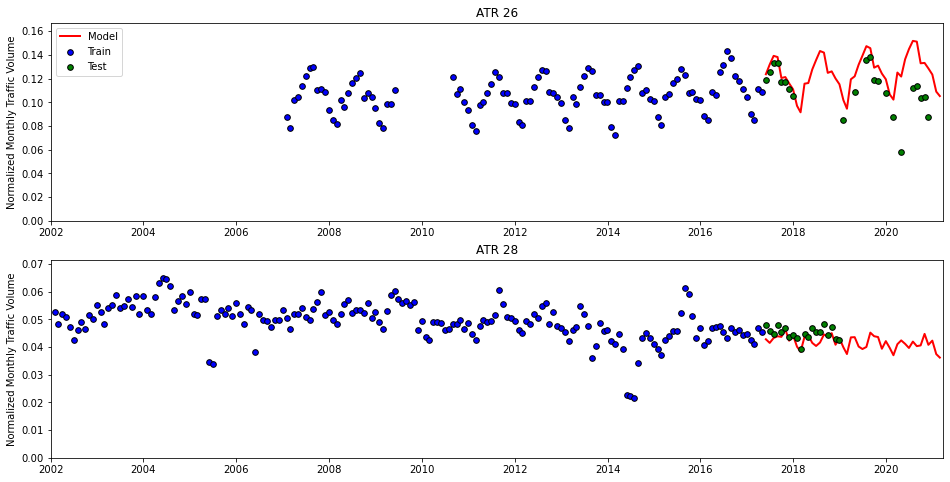

In [947]:
test_model.plot(['26','28'])

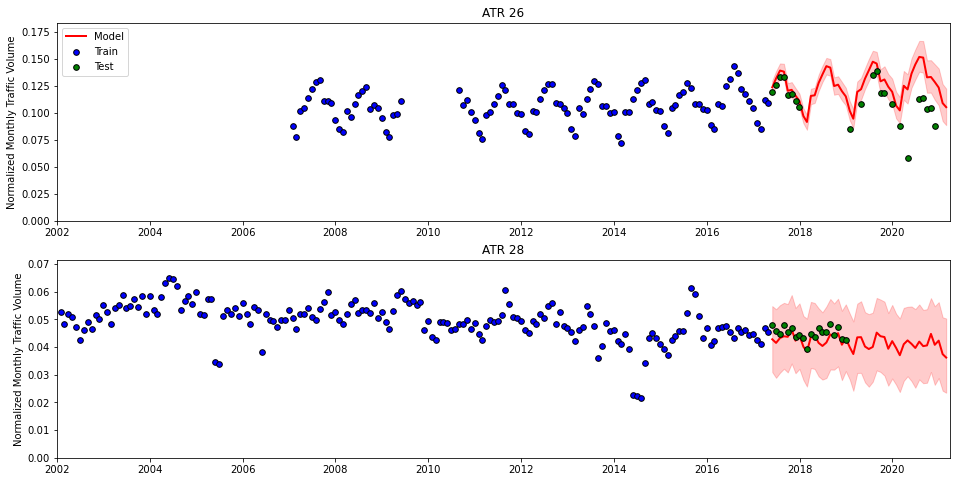

In [948]:
test_model.plot(['26','28'], margin_of_error=True)

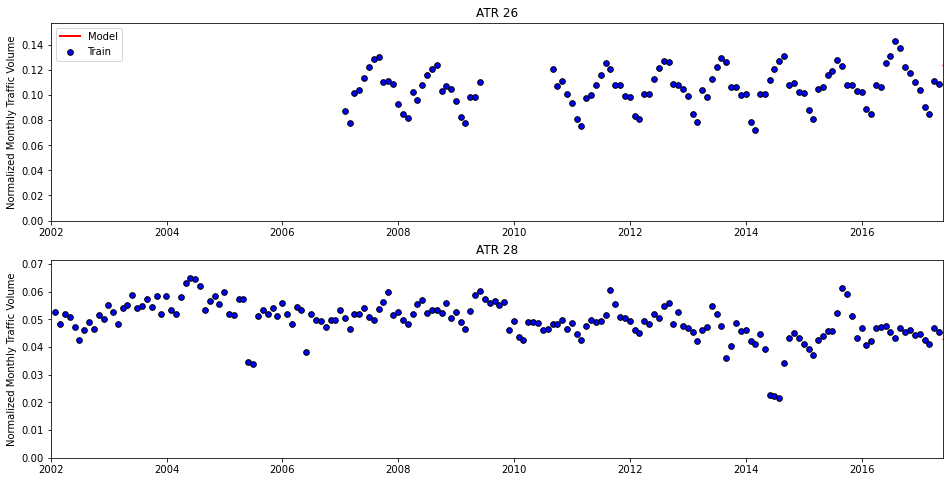

In [949]:
test_model.plot(['26','28'], margin_of_error=True, xrange='train')

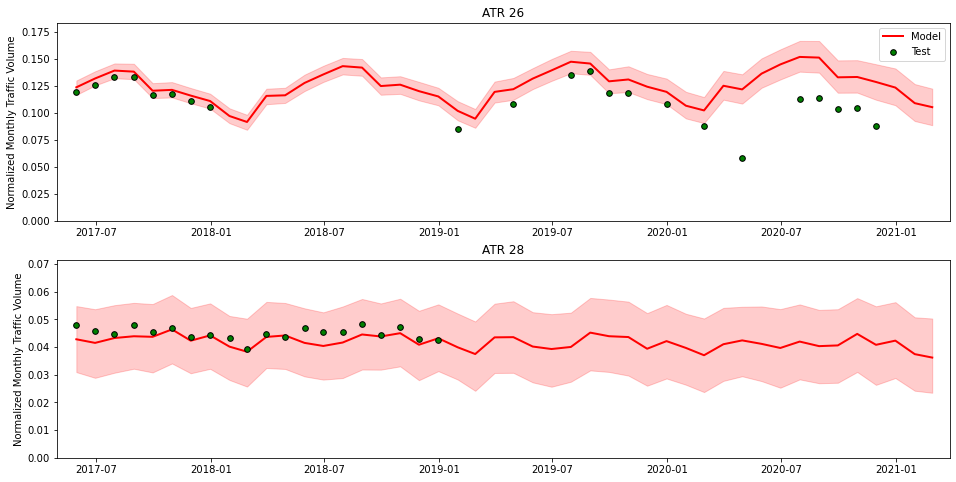

In [950]:
test_model.plot(['26','28'], margin_of_error=True, xrange='test')

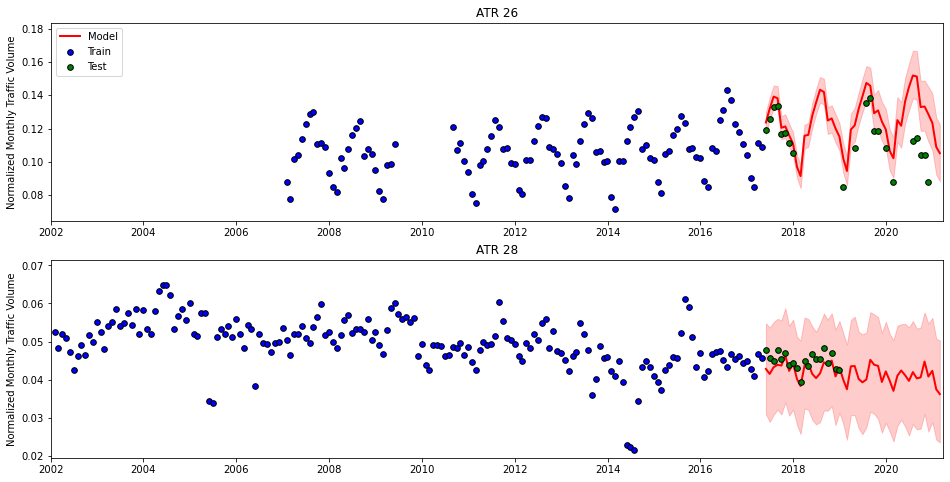

In [951]:
test_model.plot(['26','28'], margin_of_error=True, yrange='fit')

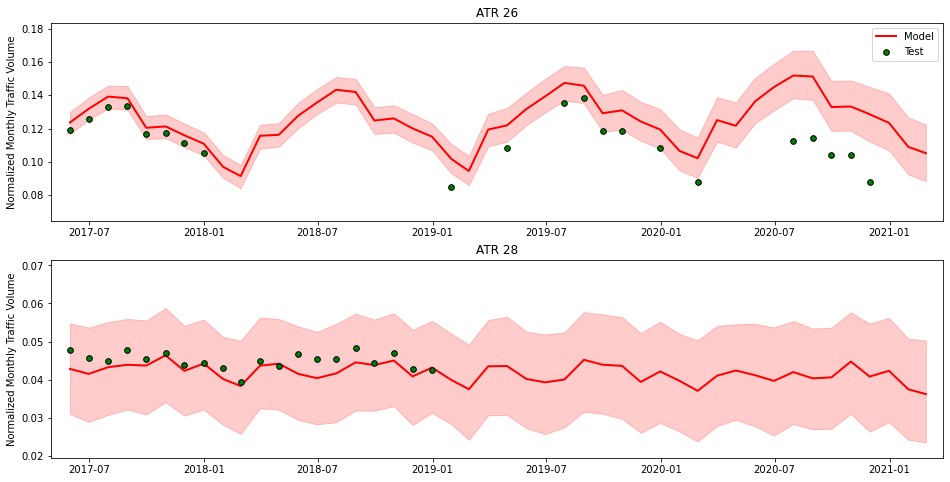

In [952]:
test_model.plot(['26','28'], margin_of_error=True, xrange='test', yrange='fit')

In [953]:
test_model.predict(tr_df, margin_of_error=True);

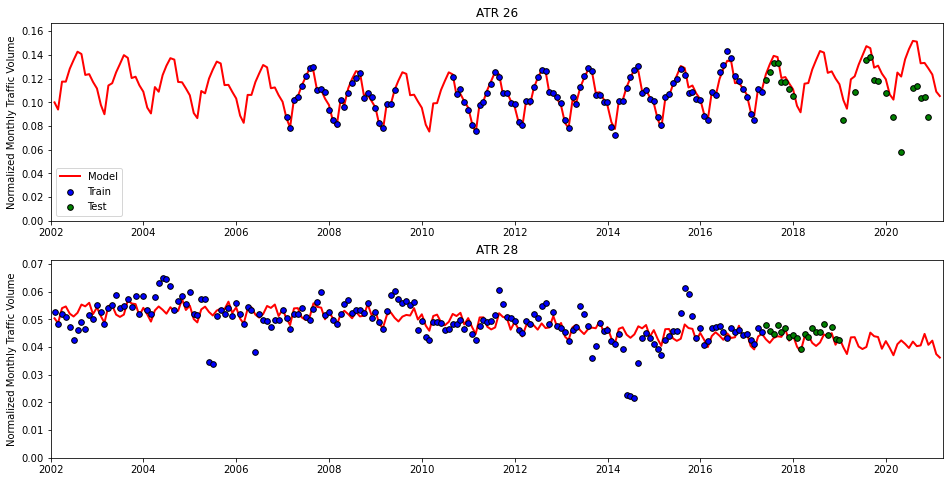

In [954]:
test_model.plot(['26','28'], predictions='full')

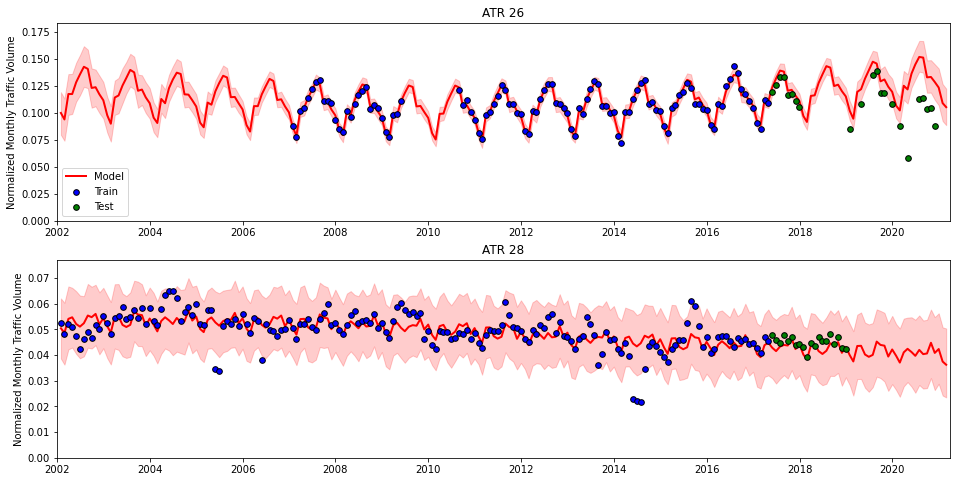

In [955]:
test_model.plot(['26','28'], margin_of_error=True, predictions='full')

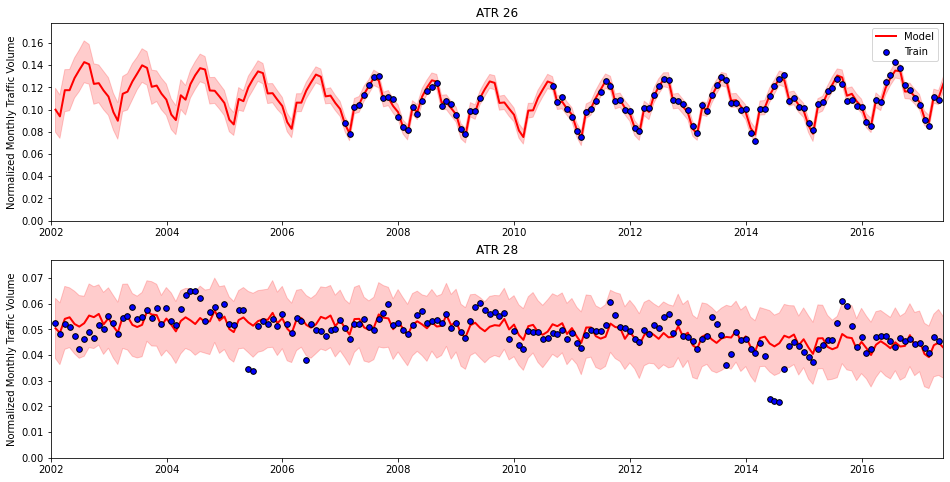

In [956]:
test_model.plot(['26','28'], margin_of_error=True, xrange='train', predictions='full')

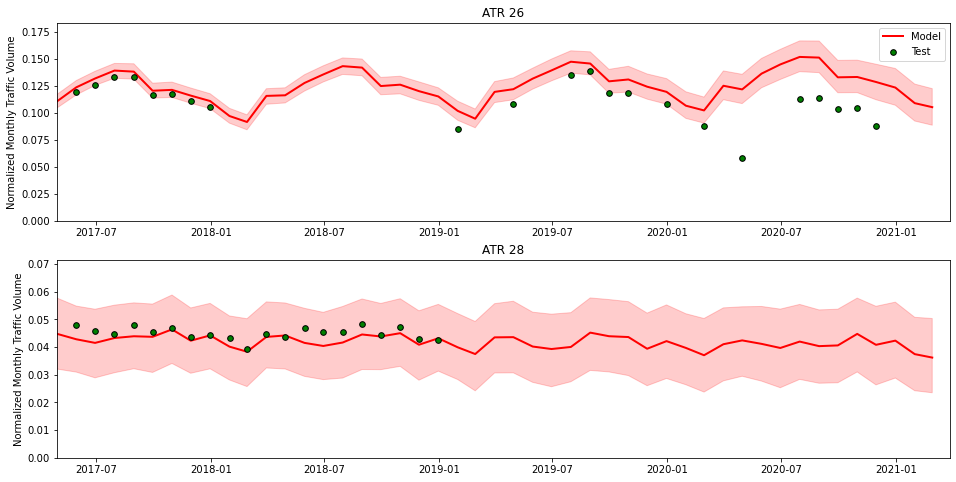

In [957]:
test_model.plot(['26','28'], margin_of_error=True, xrange='test', predictions='full')

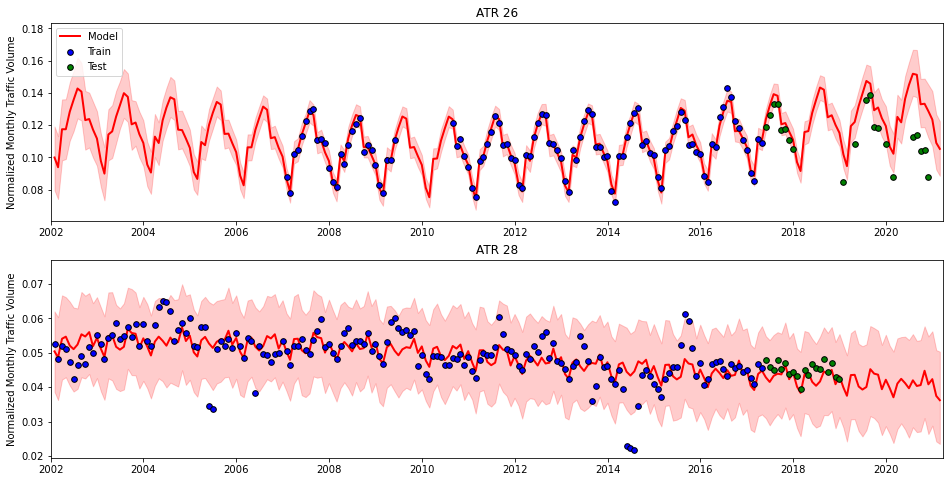

In [958]:
test_model.plot(['26','28'], margin_of_error=True, yrange='fit', predictions='full')

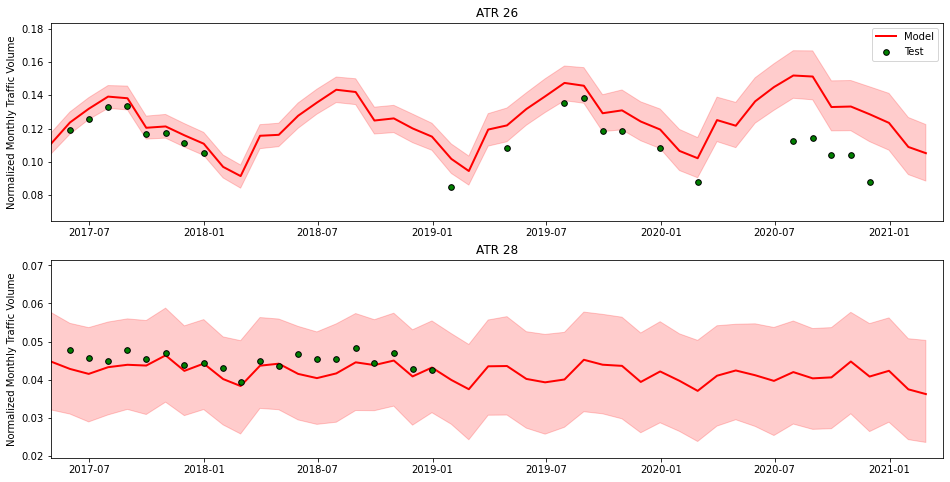

In [959]:
test_model.plot(['26','28'], margin_of_error=True, xrange='test', yrange='fit', predictions='full')

## Baseline

In [980]:
class baseline_model(model):
    def __init__(self, train_df, test_df, lag=1):
        model.__init__(self, train_df, test_df)

        self._model = lag
    
#     def fit(self, train_df=None, changepoint_prior_scale=None):
#         self._changepoint_prior_scale = changepoint_prior_scale
#         model.fit(self, train_df)

    def _fit_implementation(self):
        pass
        
    def _predict_implementation(self, test_df, margin_of_error=False):
        # Returns a data frame with same columns and index as test_df
        df = self._train_df.copy()
        lag = self._model
        for idx in test_df.index:
            df.loc[idx,:] = df.iloc[-lag,:]
            
        pred_df = df.iloc[-len(test_df):]
        
        return pred_df
            

In [981]:
baseline_1M = baseline_model(imputed_train_df,test_df,1)

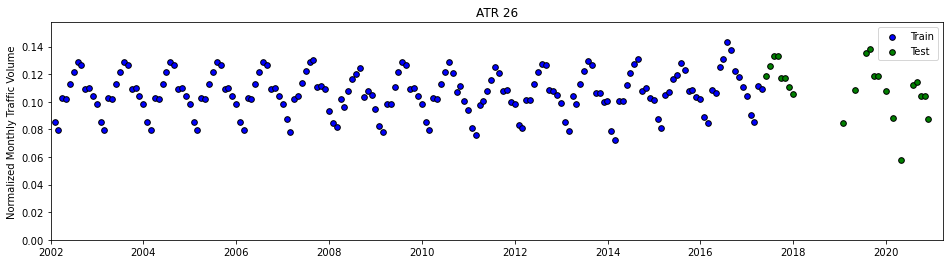

In [982]:
baseline_1M.plot()

In [983]:
baseline_1M.predict()

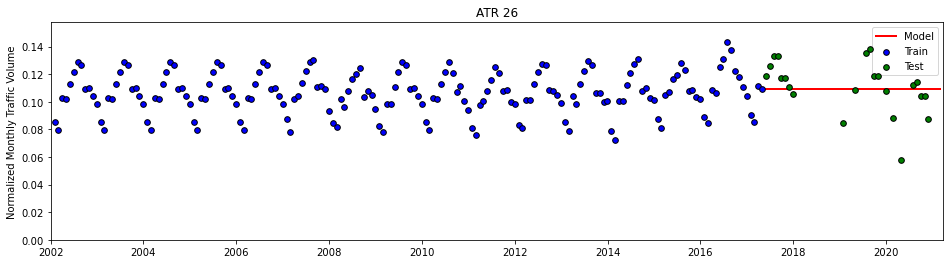

In [984]:
baseline_1M.plot()

In [985]:
baseline_12M = baseline_model(imputed_train_df,test_df,12)

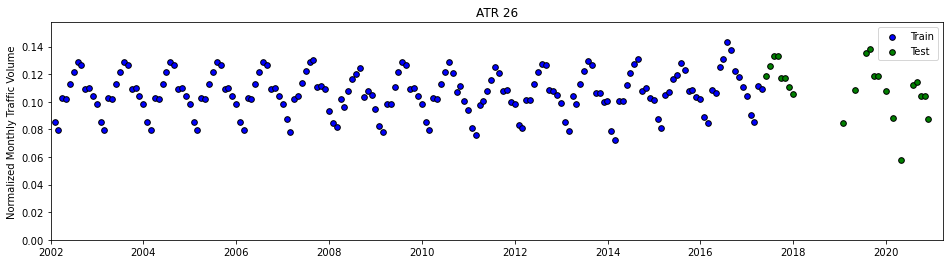

In [988]:
baseline_12M.plot()

In [989]:
baseline_12M.predict()

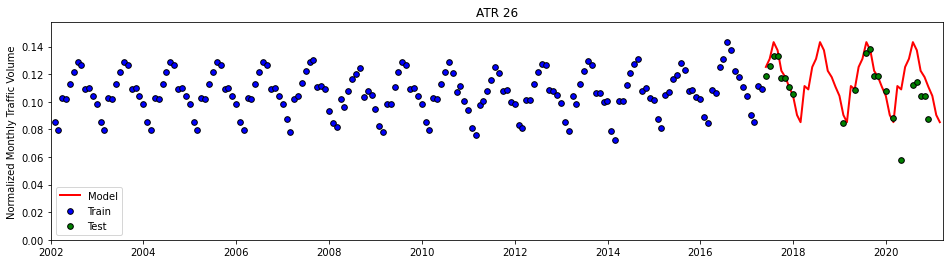

In [990]:
baseline_12M.plot()

## Prophet

In [941]:
class prophet_model(model):
    def __init__(self, train_df, test_df, default_changepoint_prior_scale = 0.05):
        model.__init__(self, train_df, test_df)
        
        # 0.05 is the default value for Prophet
        self._default_changepoint_prior_scale = default_changepoint_prior_scale
        
    # Prophet expects a data frame with 2 columns. One column 'ds' with the time stamps and one column 'y' with the data.
    def produce_prophet_series(self, y):
        df = pd.DataFrame({'ds': y.index, 'y':y})
        return df
    
    def fit(self, train_df=None, changepoint_prior_scale=None):
        self._changepoint_prior_scale = changepoint_prior_scale
        model.fit(self, train_df)

    def _fit_implementation(self):
        # There should be one Prophet model trained for every column of the training data frame
        prophet = {}
        
        if self._changepoint_prior_scale is None:
            changepoint_prior_scale = self._default_changepoint_prior_scale
            
        for col in self._train_df:
            y = self.produce_prophet_series(self._train_df[col])
            model = Prophet(daily_seasonality=False, weekly_seasonality=False, 
                            changepoint_prior_scale=changepoint_prior_scale,
                            mcmc_samples=300,
                           interval_width=0.95) # TODO: Allow adjustable confidence levels
            model.fit(y)
            prophet[col] = model
        
        return prophet
        
    def _predict_implementation(self, test_df, margin_of_error=False):
        # Returns a data frame with same columns and index as test_df
        predictions = {}
        if margin_of_error:
            predictions_upper = {}
            predictions_lower = {}
            
        # To make predictions, the Prophet model requires the number of time periods to project into the future
        test_idx = test_df.index
        full_idx = self._train_df.index.union(test_idx)
        future_periods = len(full_idx) - len(self._train_df.index)
        prediction_length = len(test_idx)
        
        for col in test_df:
            model = self._model[col]
            prediction_frame = model.make_future_dataframe(periods=future_periods, freq=test_df.index.freq)
            model_prediction = model.predict(prediction_frame)
            yhat = model_prediction['yhat'][-prediction_length:]
            yhat.index = test_idx
            predictions[col] = yhat
            
            if margin_of_error:
                yhat_upper = model_prediction['yhat_upper'][-prediction_length:]
                yhat_upper.index = test_idx
                predictions_upper[col] = yhat_upper
                
                yhat_lower = model_prediction['yhat_lower'][-prediction_length:]
                yhat_lower.index = test_idx
                predictions_lower[col] = yhat_lower
        
        prediction = pd.DataFrame(predictions)
        
        if margin_of_error:
            prediction_lower = pd.DataFrame(predictions_lower)
            prediction_upper = pd.DataFrame(predictions_upper)
            return prediction, prediction_lower, prediction_upper
        else:
            return prediction

In [63]:
scores = {}

In [64]:
%%time
ProphetModel = prophet_model()
scores['prophet'] = evaluate_model(nonimputed_train_df, test_df, ProphetModel)
scores['prophet']

INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


Wall time: 2min 54s


{'mean_squared_error': 0.08914718929321007,
 'mean_absolute_error': 1.0765194925515318}

In [65]:
%%time
ProphetImputed = prophet_model()
scores['prophet_imputed'] = evaluate_model(imputed_train_df, test_df, ProphetModel)
scores['prophet_imputed']

Wall time: 2min 18s


{'mean_squared_error': 0.08911280899549585,
 'mean_absolute_error': 1.0810509699099582}

## SARIMA

Use auto-arima to determine best parameters.

In [962]:
def fit_arima(train_df, information_criterion='aic', scoring='mse', out_of_sample_size=None):
    '''
    information_criterion can be any of 'aic', 'bic', or 'hqic'. Ignored if out_of_sample_size is not None
    scoring can be either of 'mse', 'mae'. Ignored if out_of_sample_size is None.
    '''
    df = train_df.copy()
    
    # Evaluate val_holdout
    # If None, nothing is heldout.
    # If a positive integer, that many entries are heldout.
    # If a float between 0 and 1, that proportion of entries are heldout.
    # All other cases, val_holdout holds nothing out.
    if out_of_sample_size is not None:
        if isinstance(out_of_sample_size, int):
            if out_of_sample_size <= 0:
                out_of_sample_size = 0
        elif isinstance(out_of_sample_size, float):
            if out_of_sample_size > 0 and out_of_sample_size < 1:
                out_of_sample_size = int(len(train_df) * out_of_sample_size)
            else:
                out_of_sample_size = None
        else:
            out_of_sample_size = None

    arima_parameters = {}
    for col in df:
        y = df[col]
        if out_of_sample_size is None:
            auto = pmdarima.arima.auto_arima(y, seasonal=True, m=12, information_criterion=information_criterion)
        else:
            auto = pmdarima.arima.auto_arima(y, seasonal=True, m=12, scoring=scoring, 
                                             out_of_sample_size=out_of_sample_size)
            
        col_parameters = {
            'order': auto.order,
            'seasonal_order': auto.seasonal_order,
            'with_intercept': auto.with_intercept
        }
        
        arima_parameters[col] = col_parameters
        
    return arima_parameters

In [964]:
%%time
arima_aic = fit_arima(imputed_train_df)

C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encoun

Wall time: 1h 12min 38s


In [965]:
%%time
arima_mse = fit_arima(imputed_train_df, out_of_sample_size=0.1)

C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(2,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\site-packages\pmdarima\arima\arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\wodar\anaconda3\envs\tensorflow-gpu\lib\s

Wall time: 1h 34min 59s


In [ ]:
class sarima_model(model):
    def __init__(self):
        self._models = None
    
    def fit(self, train_df):
        self._models = {}
        
        for col in train_df:
            y = train_df[col]
            auto = pmdarima.arima.auto_arima(y, seasonal=True, m=12)
            order = auto.order
            seasonal_order = auto.seasonal_order
            
            model = Prophet(daily_seasonality=False, weekly_seasonality=False, 
                            changepoint_prior_scale=changepoint_prior_scale)
            model.fit(y)
            self._models[col] = model
            
    def predict(self, test_df):
        # test_df should have the same columns as train_df
        # Returns a data frame with same columns as train_df and same index as test_df
        predictions = {}
        
        for col in test_df:
            model = self._models[col]
            # TODO: allow frequency to change.
            future = model.make_future_dataframe(periods=len(test_df), freq='M')
            forecast = model.predict(future)
            start_idx = len(future) - len(test_df)
            yhat = forecast['yhat'][start_idx:]
            yhat.index = test_df.index
            predictions[col] = yhat   
        
        prediction = pd.DataFrame(predictions)
        self._prediction = prediction
        return prediction

In [76]:
pmd = pmdarima.arima.auto_arima(imputed_train_df['26'], seasonal=True, m=12)

In [81]:
pmd.order

(0, 1, 1)

In [82]:
pmd.seasonal_order

(1, 1, 2, 12)

In [77]:
dir(pmd)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_exog',
 '_check_n_features',
 '_fit',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_warn_for_older_version',
 'aic',
 'aicc',
 'arima_res_',
 'arparams',
 'arroots',
 'bic',
 'bse',
 'conf_int',
 'df_model',
 'df_resid',
 'fit',
 'fit_predict',
 'fit_with_exog_',
 'get_params',
 'hqic',
 'maparams',
 'maroots',
 'maxiter',
 'method',
 'nobs_',
 'oob',
 'oob_',
 'oob_preds_',
 'order',
 'out_of_sample_size',
 'params',
 'pkg_version_',
 'plot_diagnostics',
 'pr

In [74]:
pmdarima.arima.auto_arima(imputed_train_df['27'], seasonal=True, m=12)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [75]:
pmdarima.arima.auto_arima(imputed_train_df['28'], seasonal=True, m=12)

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [86]:
pmd.predict(len(test_df['26']))

array([0.12375344, 0.13074139, 0.13992916, 0.1367599 , 0.11969821,
       0.11833852, 0.11173771, 0.10735528, 0.09305092, 0.08761999,
       0.11260122, 0.11127569, 0.12468391, 0.13154886, 0.14014862,
       0.13718565, 0.11997108, 0.11934448, 0.11297153, 0.10931666,
       0.0948441 , 0.08953668, 0.11424249, 0.11301075, 0.12671322,
       0.13361076, 0.14236631, 0.13934869, 0.12217462, 0.1213538 ,
       0.11492048, 0.11107284, 0.09664485, 0.0913047 , 0.11608348,
       0.11482689, 0.12845141, 0.13534031, 0.14405458, 0.14105144,
       0.12386664, 0.12309728, 0.11667995, 0.11288339, 0.09844359,
       0.09311211])